Importer les librairies nécessaires

In [1]:
!pip install langchain

In [2]:
!pip install transformers

In [1]:
import csv
import os
import cv2
import random
import matplotlib.pyplot as plt
import json

from langchain import PromptTemplate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

C:\Users\CYTech Student\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1>Constitution du dataset multi-modal</h1>

Utiliser le fichier d’annotations fourni avec le dataset Data_Herbier_trait_segmentation pour générer des descriptions textuelles des images.

In [2]:
# read the csv file and store the data in a list of dictionaries

annotations = []

with open('annotations-herbier.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:

        # change "ANGÂ\xa0419,00" to "ANG000419" by removing ',00' and replacing 'Â\xa0' (space) by as many 0 as needed
        for i in range(len(row['code']), 0, -1):
            match row['code'][i-1]:
                case '0':
                    row['code'] = row['code'][:i-1]
                case ',':
                    row['code'] = row['code'][:i-1]
                    break
                case _ :
                    break
        row['code'] = row['code'][:3] + row['code'][5:].zfill(6)

        # convert '1.0' and '0.0' to True and False
        row['epines'] = bool(row['epines'])
        row['feuille_ext_acuminee'] = bool(row['feuille_ext_acuminee'])

        annotations.append(row)

print(len(annotations), 'annotations loaded')

2530 annotations loaded


In [3]:
annotations[0]

{'code': 'ANG000419', 'epines': True, 'feuille_ext_acuminee': True}

In [4]:
# Keep only annotations that have a corresponding image in the images folder

annotations = filter(lambda row: os.path.exists(f"images/{row['code']}.jpg"), annotations)
annotations = list(annotations)

print(len(annotations), 'annotations with images')

93 annotations with images


In [5]:
# create a prompt template

template = """Describe the plant.

Information: This plant {epines} thorns and its leaves {feuille_ext_acuminee} acuminate (tapering to a long point in a concave manner).
Description:
"""

prompt = PromptTemplate(template=template, input_variables=["epines", "feuille_ext_acuminee"])

In [6]:
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

def get_output(row):
  epines = 'has' if row['epines'] else 'does not have'
  feuille_ext_acuminee = 'are' if row['feuille_ext_acuminee'] else 'are not'
  text = prompt.invoke({"epines": epines, "feuille_ext_acuminee": feuille_ext_acuminee})
  inputs = tokenizer(text.text, return_tensors="pt")
  outputs = model.generate(**inputs)
  return tokenizer.batch_decode(outputs, skip_special_tokens=True)

In [7]:
# Generate a description for a each image
for row in annotations:
    row['description'] = get_output(row)[0]

In [8]:
# Write the descriptions to a json file
with open('descriptions.json', 'w') as jsonfile:
    json.dump(annotations,jsonfile,indent=4)

Combiner chaque image avec sa description pour créer un dataset de tuples (image, phrase).

In [9]:
# import the json file
with open('descriptions.json') as jsonfile:
    descriptions = json.load(jsonfile)

dataset = []
for desc in descriptions:
    image = cv2.imread(f"images/{desc['code']}.jpg")
    dataset.append((cv2.cvtColor(image, cv2.COLOR_BGR2RGB),desc['description']))

print(len(dataset), "images loaded")

93 images loaded


Description: This plant is a genus of thorns and its leaves are acuminate (


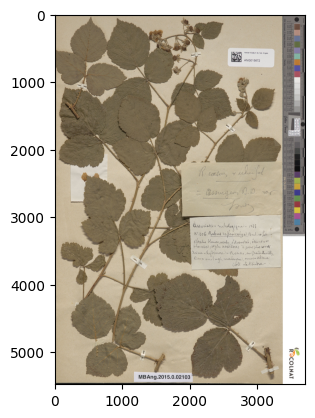

In [10]:
# print a random image with its description
random_row = random.choice(dataset)
print(f"Description: {random_row[1]}")
plt.imshow(random_row[0])
plt.show()

<h1>Choix, entraînement ou fine-tuning et comparaison de deux modèles</h1>